<a href="https://www.kaggle.com/code/mubashirjawad01/lab-02?scriptVersionId=299166858" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **1.Libraries Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Importing machine learning tools from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score



# Set plotting style
sns.set(style="whitegrid")

In [2]:
!gdown --id 1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf
To: /kaggle/working/Mall_Customers.csv
100%|██████████████████████████████████████| 3.98k/3.98k [00:00<00:00, 18.5MB/s]


# **2.Load the dataset**

In [3]:
df =  pd.read_csv("/kaggle/input/datasets/mubashirjawad01/lab-02-mall-customers-csv-dataset/Mall_Customers.csv")

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# **3.Preprocessing and Feature Engineering**

In [5]:

# Drop rows with missing values just in case
df.dropna(inplace=True)

# Drop the 'CustomerID' column as it is an identifier, not a feature
if 'CustomerID' in df.columns:
    df_unsupervised = df.drop(columns=['CustomerID'])
else:
    df_unsupervised = df.copy()

# Split the features into categorical and numerical
categorical_features = df_unsupervised.select_dtypes(include=['object']).columns
numerical_features = df_unsupervised.select_dtypes(include=['int64', 'float64']).columns

# Standard scaling for numerical features only
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(df_unsupervised[numerical_features])

# One-hot encoding for categorical features only
encoder = OneHotEncoder(drop='first')
encoded_categorical_data = encoder.fit_transform(df_unsupervised[categorical_features])

# Concatenate the scaled numerical and encoded categorical data
processed_data = np.hstack([scaled_numerical_data, encoded_categorical_data.toarray()])

# Convert to DataFrame with appropriate column names
final_columns = numerical_features.tolist() + encoder.get_feature_names_out(categorical_features).tolist()
processed_data_df = pd.DataFrame(processed_data, columns=final_columns)

# Display the first few rows to understand the structure
print(processed_data_df.head())

        Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0 -1.424569           -1.738999               -0.434801          1.0
1 -1.281035           -1.738999                1.195704          1.0
2 -1.352802           -1.700830               -1.715913          0.0
3 -1.137502           -1.700830                1.040418          0.0
4 -0.563369           -1.662660               -0.395980          0.0


# **4.Elbow Method, Apply Clustering, and Calculate Scores**

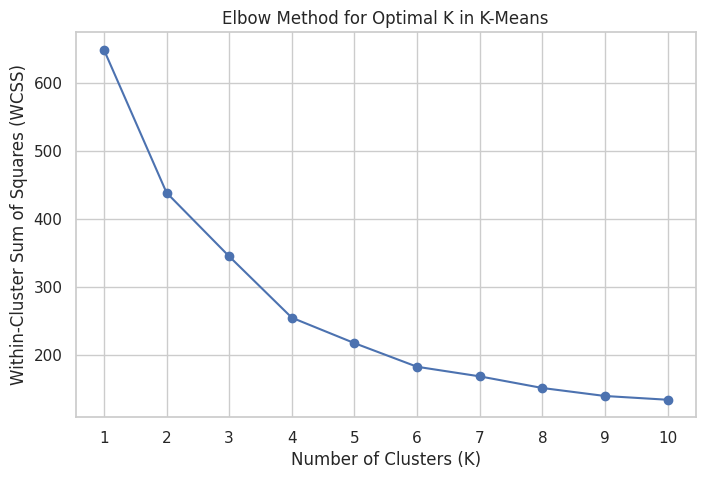

Silhouette Score (K-Means): 0.34977050035201074
Silhouette Score (DBSCAN): 0.24355898363237524
Davies-Bouldin Index (K-Means): 1.0245227921150648
Davies-Bouldin Index (DBSCAN): 1.9485638530023488


In [6]:
# 3. Calculate WCSS for a range of K values to use the Elbow Method
wcss = []
k_range = range(1, 11)  # Range of K values from 1 to 10

# Iterate through each k and calculate WCSS
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(processed_data_df)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal K in K-Means")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_range)
plt.show()

# Define number of clusters for K-Means (5 is optimal for Mall Customers based on the Elbow)
n_clusters = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, max_iter=30, random_state=42, n_init=10)
processed_data_df['KMeans_Cluster'] = kmeans.fit_predict(processed_data_df)

# Apply DBSCAN clustering (Note: eps tuned to 0.9 for Mall Customers scaled data)
dbscan = DBSCAN(eps=0.9, min_samples=5)
processed_data_df['DBSCAN_Cluster'] = dbscan.fit_predict(processed_data_df)

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
# We drop the cluster labels before doing PCA so they don't influence the geometry
pca_result = pca.fit_transform(processed_data_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster']))
processed_data_df['PCA1'] = pca_result[:, 0]
processed_data_df['PCA2'] = pca_result[:, 1]

# Calculate evaluation scores (dropping all added columns to evaluate pure data)
clean_data_for_scoring = processed_data_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'PCA1', 'PCA2'])

silhouette_kmeans = silhouette_score(clean_data_for_scoring, processed_data_df['KMeans_Cluster'])
# DBSCAN might result in only 1 cluster if parameters are off, which throws an error for Silhouette. 
# We use a try-except block just in case.
try:
    silhouette_dbscan = silhouette_score(clean_data_for_scoring, processed_data_df['DBSCAN_Cluster'])
    dbi_dbscan = davies_bouldin_score(clean_data_for_scoring, processed_data_df['DBSCAN_Cluster'])
except ValueError:
    silhouette_dbscan = "N/A (Too much noise/Only 1 cluster)"
    dbi_dbscan = "N/A"

dbi_kmeans = davies_bouldin_score(clean_data_for_scoring, processed_data_df['KMeans_Cluster'])

# Print evaluation scores
print(f"Silhouette Score (K-Means): {silhouette_kmeans}")
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan}")
print(f"Davies-Bouldin Index (K-Means): {dbi_kmeans}")
print(f"Davies-Bouldin Index (DBSCAN): {dbi_dbscan}")

# **5.Visualization with PCA**

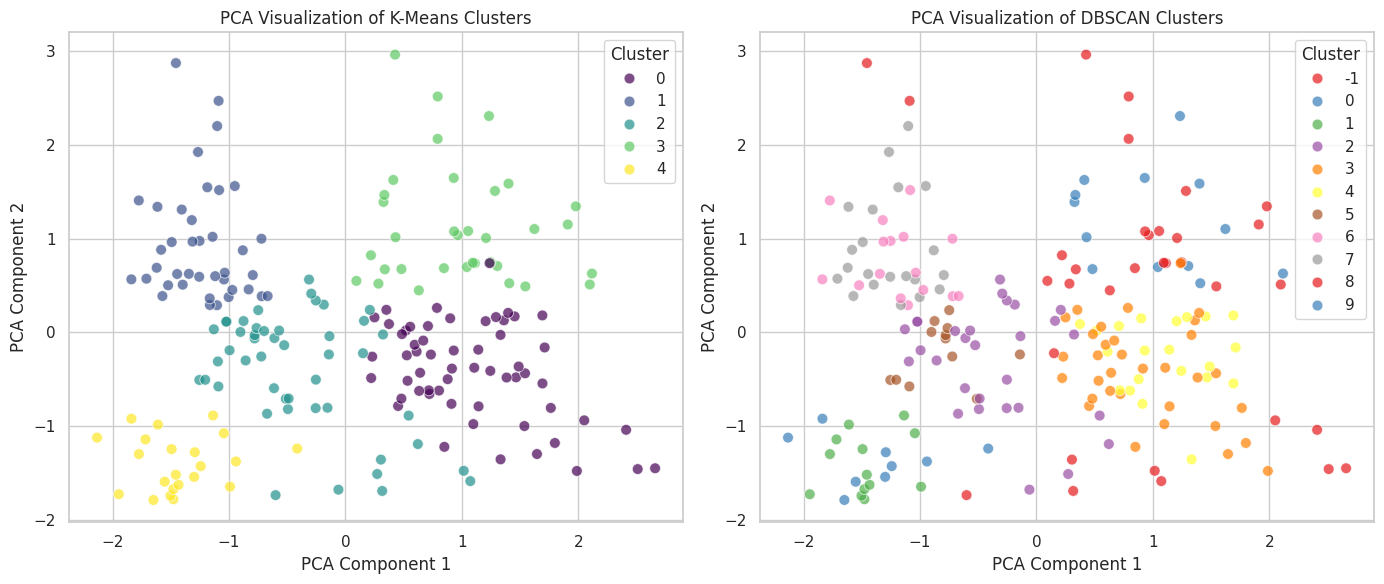

In [7]:
# 4. Plot PCA visualization for K-Means and DBSCAN clusters
plt.figure(figsize=(14, 6))

# Plot for K-Means
plt.subplot(1, 2, 1)
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("PCA Visualization of K-Means Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')

# Plot for DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set1', s=60, alpha=0.7)
plt.title("PCA Visualization of DBSCAN Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

# **6.GMM (Gaussian Mixture Model)**

Silhouette Score (GMM): 0.33231744771690586
Davies-Bouldin Index (GMM): 1.0383109124009209


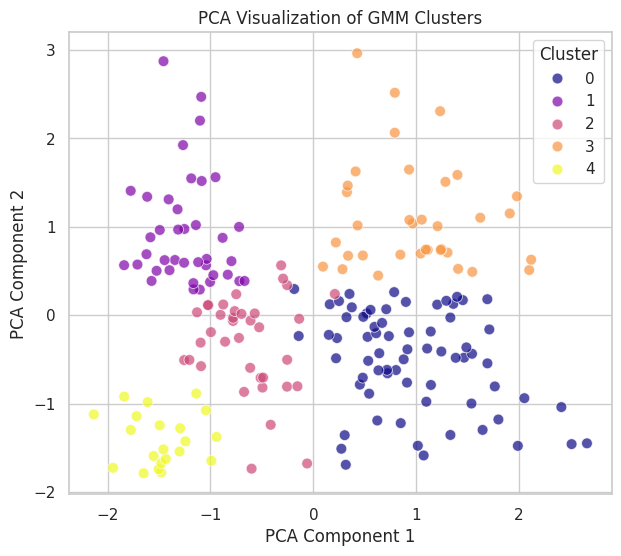

In [8]:
# 5. GMM
# Apply Gaussian Mixture Model with the same number of clusters as K-Means (5 clusters)
gmm = GaussianMixture(n_components=n_clusters, random_state=42)

# Drop the columns we added so we only fit GMM on the processed data
data_for_gmm = processed_data_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'PCA1', 'PCA2'])
processed_data_df['GMM_Cluster'] = gmm.fit_predict(data_for_gmm)

# Calculate silhouette and Davies-Bouldin scores for GMM
clean_data_for_gmm_scoring = processed_data_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'GMM_Cluster', 'PCA1', 'PCA2'])

silhouette_gmm = silhouette_score(clean_data_for_gmm_scoring, processed_data_df['GMM_Cluster'])
dbi_gmm = davies_bouldin_score(clean_data_for_gmm_scoring, processed_data_df['GMM_Cluster'])

# Print the evaluation scores for GMM
print(f"Silhouette Score (GMM): {silhouette_gmm}")
print(f"Davies-Bouldin Index (GMM): {dbi_gmm}")

# PCA visualization for GMM clusters
plt.figure(figsize=(7, 6))
sns.scatterplot(data=processed_data_df, x='PCA1', y='PCA2', hue='GMM_Cluster', palette='plasma', s=60, alpha=0.7)
plt.title("PCA Visualization of GMM Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()